In [112]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
column_names = []
column_matrix = None
num_of_columns = 0
column_dtype = None
datatype = {0:"int",1:"float",2:"object"}

In [159]:
def csv_reader(filename,sep=','):
    #Exception handling for types and file not found errors.
    try:
        with open(filename,'r') as csvreader:
            csv_file = np.genfromtxt((csvreader),invalid_raise=False, dtype=None,delimiter=sep,encoding=None,skip_header=0)
        a= iter(csv_file)
        headers = next(a)
        return csv_file
    except FileNotFoundError as e:
        print(e)
    except TypeError as t:
        print(t)
    except UnboundLocalError as f:
        print(f)
    except Exception as e:
        print(e)

In [115]:
# Returns data matrix
def get_data_matrix():
    return column_matrix

In [116]:
# All statistics functions
def get_min(col):
    return np.min(col)
    
def get_max(col):
    return np.max(col)

def get_count(col):
    return col.size

def get_std(col):
    return round(np.std(col))

def get_Q1(col):
    q1=np.quantile(col,.25)
    return round(q1)
    
def get_Q2(col):
    q2=np.quantile(col,.50)
    return round(q2)

def get_Q3(col):
    q3=np.percentile(col,.75)
    return round(q3)

def get_unique(col):
    return np.unique(col)[1]

# Partially code copied from https://stackoverflow.com/questions/19909167/how-to-find-most-frequent-string-element-in-numpy-ndarray
def get_top(col):
    unique,pos = np.unique(col,return_inverse=True) #Finds all unique elements and their positions
    counts = np.bincount(pos)                     #Count the number of each unique element
    maxpos = counts.argmax()  
    return col[maxpos]

def outlier_percent(col):
    #Logic is to find the upper and lower limit and check how many fall into the range and calculate the percentage of those that don't.
    q1=get_Q1(col)
    q3 = get_Q3(col)
    in_range=[]
    iqr= q3-q1
    lower_limit = q1-(1.5*iqr)
    upper_limit = q3+(1.5*iqr)
    #Handling error for 0 division.
    try:
        for i in col:
            if i>upper_limit:
                if i<lower_limit:
                    in_range.append(i)
                pass
        outlier_count = len(col)-len(in_range)*100
        outlier_per = abs(outlier_count/len(col))
        return round(outlier_per)
    except ZeroDivisionError:
        return print("No outliers")
    pass

In [117]:
# Returns high-level statistics of categorical columns
def get_stat_categorical(idx):
    stat_dict = {}
    matrix =  get_data_matrix()
    processed_column = np.array([])
    
    for val in matrix[:,idx]:
        if val != '':
            processed_column = np.append(processed_column,(val))
            
    stat_dict["min"] = np.NaN
    stat_dict["max"] = np.NaN
    stat_dict["count"] = get_count(processed_column)
    stat_dict["std"] = np.NaN
    stat_dict["Q1"] = np.NaN
    stat_dict["Q2"] = np.NaN
    stat_dict["Q3"] = np.NaN
    stat_dict["Unique"] = get_unique(processed_column)
    stat_dict["Top"] = get_top(processed_column)
    stat_dict["OP"] = np.NaN
#     print("-------------------")
#     print("Processed categorical:",stat_dict)
    return stat_dict

In [118]:
# Returns high-level statistics of numerical columns
def get_stat_numeric(idx):
    stat_dict = {}
    matrix =  get_data_matrix()
    processed_column = np.array([])
   
    if column_dtype[idx] == 0:
        # column is int type
        for val in matrix[:,idx]:
            if val != '':
                processed_column = np.append(processed_column, int(val))
#         print("-------------------")
#         print("Processed int:",processed_column)
    else:
        
        # column is float type
        for val in matrix[:,idx]:
            if val != '':
                processed_column = np.append(processed_column, float(val))
#         print("-------------------")
#         print("Processed float:",processed_column)
                
    stat_dict["min"] = get_min(processed_column)
    stat_dict["max"] = get_max(processed_column)
    stat_dict["count"] = get_count(processed_column)
    stat_dict["std"] = get_std(processed_column)
    stat_dict["Q1"] = get_Q1(processed_column)
    stat_dict["Q2"] = get_Q2(processed_column)
    stat_dict["Q3"] = get_Q3(processed_column)
    stat_dict["Unique"] = np.NaN
    stat_dict["Top"] = np.NaN
    stat_dict["OP"] = outlier_percent(processed_column)
        
#     print(stat_dict)
    return stat_dict

In [119]:
# Return high-level statistics e.g. min,max,count etc
def get_statistics():
    stats ={}
    # check data type for each columns
    for idx,col_name in enumerate(column_names):
        if column_dtype[idx] in [0,1]:
            # We have numeric column type
            stats[col_name] = get_stat_numeric(idx)
        else:
            # We have object column type
            stats[col_name] = get_stat_categorical(idx)
            
#     print("-------------------")
#     print("final stats : ",stats)   
    return stats

In [120]:
# Checks data types Return 0 for int, 1 for float and 2 for object
def check_dtypes(value):
    if not value:
        return 0
    try:
        # Convert it into integer
        val = int(value)
        # We have integer type
        return 0
    except ValueError:
        try:
            # Convert it into float
            val = float(value)
            # We have float type
            return 1
        except ValueError:
            # We have object type 
            return 2

In [121]:
# Calculate datatype for each columns
def calculate_dtype():
    for col in range(num_of_columns):
        current_column = column_matrix[1:,col]
        # Loop through each value of a column
        for val in current_column:
            datatype = check_dtypes(val)
            column_dtype[col] = max(column_dtype[col],datatype)

In [156]:
# Partial code used from https://towardsdatascience.com/simple-little-tables-with-matplotlib-9780ef5d0bc4
def plot_stats(stats):
    stat_names = ["min","max","count","std","Q1","Q2","Q3","Unique","Top","OP"] 
    feature_names = [] 
    data = [] 

    for feature, value in stats.items():
        feature_names.append(feature)
        row =[]
        for stat_name in stat_names:
            row.append(value[stat_name])
        data.append(row)

#     print("data:",data)
    title_text = 'Statistics'

    # Get some lists of color specs for row and column headers
    rcolors = plt.cm.BuPu(np.full(len(feature_names), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(stat_names), 0.1))
    # Create the figure. Setting a small pad on tight_layout
    # seems to better regulate white space. Sometimes experimenting
    # with an explicit figsize here can produce better outcome.
    plt.figure(linewidth=4,
               tight_layout={'pad':1},
          )
    # Add a table at the bottom of the axes
    the_table = plt.table(cellText=data,
                          rowLabels=feature_names,
                          rowColours=rcolors,
                          rowLoc='right',
                          colColours=ccolors,
                          colLabels=stat_names,
                          loc='center')
    # Scaling is the only influence we have over top and bottom cell padding.
    # Make the rows taller (i.e., make cell y scale larger).
    the_table.scale(4, 4.5)
    # Hide axes
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Hide axes border
    plt.box(on=None)
    # Add title
    plt.suptitle(title_text)

C:\Users\Yugant\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


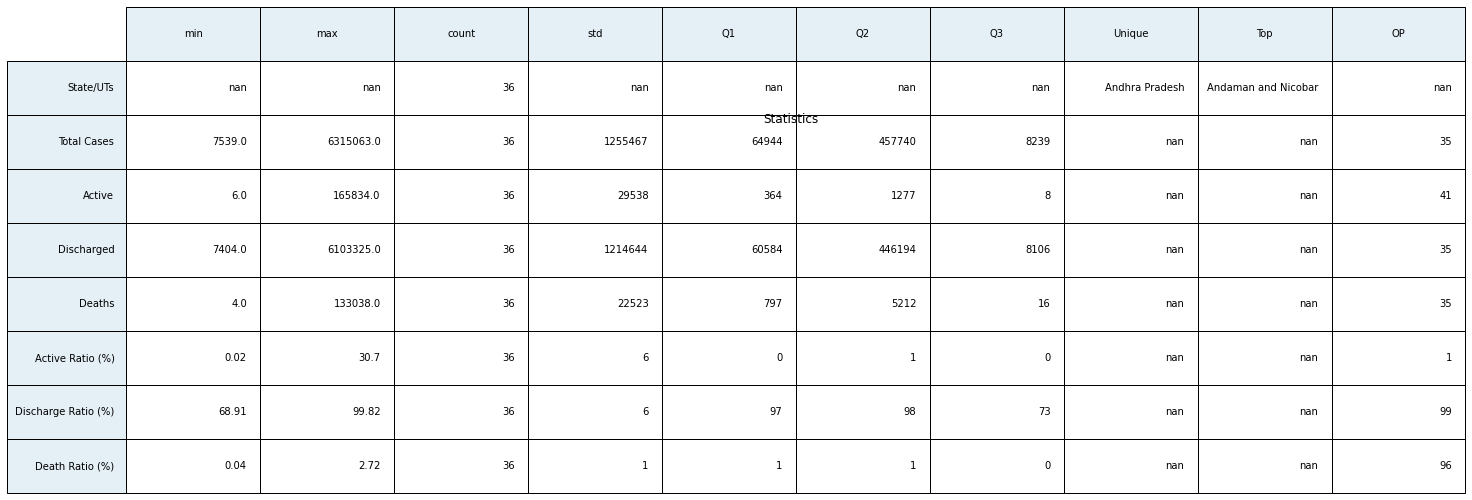

In [157]:
if __name__ == "__main__":
    file = csv_reader('Latest_Covid_India.csv')
    # Get column names
    column_names = file[0,:]
    # Caculate length of columns
    num_of_columns = len(column_names)
    # Initialize column data types to zero
    column_dtype = np.zeros(num_of_columns)
    # Get data except column names
    column_matrix = file[1:,:]             
    
    # Calculate data types for each columns
    calculate_dtype()            
    # Return high level stats of each columns
    stats = get_statistics()
#     print("stats:",stats)
    plot_stats(stats)